In [12]:
import matplotlib.pyplot as plt

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "_scripts"))

In [15]:
import networkx as nx
from eppy.bunch_subclass import EpBunch
from geomeppy import IDF

from case_edits.ezcase import *
from helpers.ep_helpers import *
from helpers.ep_geom_helpers import *
from helpers.geometry_interfaces import *
from helpers.helpers import *
from plan.helpers import get_plans_from_file
from network.network import *
from network.visuals import *
from subsurfaces.logic import get_connecting_surface
from helpers.variables import *
from helpers.variable_interfaces import *
from munch import Munch
from helpers.read_sql import *

from dataclasses import dataclass
from pprint import pprint
import sqlite3
from case_edits.epcase import EneryPlusCaseEditor

In [16]:
surf_tes = "/System/Volumes/Data/Applications/EnergyPlus-22-2-0/ExampleFiles/SurfaceZonePropTest_LocalEnv.idf"
sidf = IDF(surf_tes)


In [17]:
case2 = EneryPlusCaseEditor("tests/test23_surfs", starting_case=surf_tes)
case2

EPCaseEditor(tests/test23_surfs)

In [18]:
from helpers.output_requests import request_sql


case2.idf = request_sql(case2.idf )

In [19]:
case2.compare_and_save()
# case2.run_idf(force_run=True)

out.idf exists
IDF has changed: True


In [20]:
inputs_dir = "case_red_d3"
outputs_dir = "tests/test22_svg2plan"

case = initialize_case(outputs_dir)
path_to_input = get_path_to_inputs(inputs_dir)
path_to_output = get_path_to_outputs(case)
pairs = get_subsurface_pairs_from_case(path_to_input)

In [47]:
path_to_output2 = get_path_to_outputs(case2)
path_to_output2

PosixPath('cases/tests/test23_surfs')

In [26]:
all_variables.zone.wind

{'speed': 'Zone Average Outdoor Air Wind Speed',
 'direction': 'Zone Outdoor Air Wind Direction'}

In [25]:
case = create_ezcase(outputs_dir, inputs_dir)
idf = case.idf
case.run_idf(force_run=True)

out.idf exists
IDF has changed: False
idf has changed - running case

/Applications/EnergyPlus-22-2-0/energyplus --weather /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/weather_data/PALO_ALTO/CA_PALO-ALTO-AP_724937_23.EPW --output-directory /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/tests/test22_svg2plan/results --idd /Applications/EnergyPlus-22-2-0/Energy+.idd /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/base/01example/Minimal_AP_7d87d2.idf

EnergyPlus Starting
EnergyPlus, Version 22.2.0-c249759bad, YMD=2024.10.21 15:55
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 07/01/2017 for SUMMERDAY
Writing tabular output file results using HTML format.
Writing final SQL reports
EnergyPlus Run Time=00hr 

EnergyPlus Completed Successfully.


In [65]:
sorted([i.Variable_Name for i in idf.idfobjects["OUTPUT:VARIABLE"]])

['AFN Linkage Node 1 to Node 2 Volume Flow Rate',
 'AFN Linkage Node 2 to Node 1 Volume Flow Rate',
 'AFN Node Temperature',
 'AFN Node Total Pressure',
 'AFN Node Wind Pressure',
 'AFN Surface Venting Window or Door Opening Factor',
 'AFN Zone Ventilation Air Change Rate',
 'AFN Zone Ventilation Sensible Heat Gain Rate',
 'AFN Zone Ventilation Sensible Heat Loss Rate',
 'AFN Zone Ventilation Volume',
 'Site Diffuse Solar Radiation Rate per Area',
 'Site Direct Solar Radiation Rate per Area',
 'Site Outdoor Air Dewpoint Temperature',
 'Site Outdoor Air Drybulb Temperature',
 'Site Outdoor Air Wetbulb Temperature',
 'Site Solar Altitude Angle',
 'Site Solar Azimuth Angle',
 'Site Wind Direction',
 'Site Wind Speed',
 'Surface Outside Face Outdoor Air Wind Direction',
 'Surface Outside Face Outdoor Air Wind Speed',
 'Zone Air Heat Balance Air Energy Storage Rate',
 'Zone Air Heat Balance Interzone Air Transfer Rate',
 'Zone Air Heat Balance Outdoor Air Transfer Rate',
 'Zone Air Heat Bal

In [26]:
sql = get_sql_results(path_to_output)
sorted(sql.available_outputs)
# c = get_collection_for_variable(s2l, all_variables.zone.wind["speed"])
# c[0]


['AFN Linkage Node 1 to Node 2 Volume Flow Rate',
 'AFN Linkage Node 2 to Node 1 Volume Flow Rate',
 'AFN Node Temperature',
 'AFN Node Total Pressure',
 'AFN Node Wind Pressure',
 'AFN Surface Venting Window or Door Opening Factor',
 'AFN Zone Ventilation Air Change Rate',
 'AFN Zone Ventilation Sensible Heat Gain Rate',
 'AFN Zone Ventilation Sensible Heat Loss Rate',
 'AFN Zone Ventilation Volume',
 'Site Diffuse Solar Radiation Rate per Area',
 'Site Direct Solar Radiation Rate per Area',
 'Site Outdoor Air Dewpoint Temperature',
 'Site Outdoor Air Drybulb Temperature',
 'Site Outdoor Air Wetbulb Temperature',
 'Site Solar Altitude Angle',
 'Site Solar Azimuth Angle',
 'Site Wind Direction',
 'Site Wind Speed',
 'Surface Outside Face Outdoor Air Wind Direction',
 'Surface Outside Face Outdoor Air Wind Speed',
 'Zone Air Heat Balance Air Energy Storage Rate',
 'Zone Air Heat Balance Interzone Air Transfer Rate',
 'Zone Air Heat Balance Outdoor Air Transfer Rate',
 'Zone Air Heat Bal

In [ ]:
sql.file_path

In [189]:
all_variables.afn.linkage

{'flow12': 'AFN Linkage Node 1 to Node 2 Volume Flow Rate',
 'flow21': 'AFN Linkage Node 2 to Node 1 Volume Flow Rate'}

In [178]:
all_variables.afn.node

{'temp': 'AFN Node Temperature',
 'total_pressure': 'AFN Node Total Pressure',
 'wind_pressure': 'AFN Node Wind Pressure'}

In [179]:
validate_request(sql, all_variables.afn.node['temp'])

True

In [32]:
c = get_collection_for_variable(sql, "Surface Outside Face Outdoor Air Wind Speed")
[i.header.metadata  for i in c]

[{'type': 'Surface Outside Face Outdoor Air Wind Speed',
  'Surface': 'BLOCK 00 STOREY 0 WALL 0002'},
 {'type': 'Surface Outside Face Outdoor Air Wind Speed',
  'Surface': 'BLOCK 00 STOREY 0 WALL 0003'},
 {'type': 'Surface Outside Face Outdoor Air Wind Speed',
  'Surface': 'BLOCK 00 STOREY 0 WALL 0001_1'},
 {'type': 'Surface Outside Face Outdoor Air Wind Speed',
  'Surface': 'BLOCK 00 STOREY 0 WALL 0001_2'},
 {'type': 'Surface Outside Face Outdoor Air Wind Speed',
  'Surface': 'BLOCK 00 STOREY 0 WALL 0004_1'},
 {'type': 'Surface Outside Face Outdoor Air Wind Speed',
  'Surface': 'BLOCK 00 STOREY 0 FLOOR 0001'},
 {'type': 'Surface Outside Face Outdoor Air Wind Speed',
  'Surface': 'BLOCK 00 STOREY 0 ROOF 0001'},
 {'type': 'Surface Outside Face Outdoor Air Wind Speed',
  'Surface': 'BLOCK 01 STOREY 0 WALL 0002_1 DOOR PARTNER'},
 {'type': 'Surface Outside Face Outdoor Air Wind Speed',
  'Surface': 'BLOCK 00 STOREY 0 WALL 0003 WINDOW'},
 {'type': 'Surface Outside Face Outdoor Air Wind Spee

In [209]:
c = get_collection_for_variable(sql, all_variables.afn.node["wind_pressure"])
ext_node_col = [i for i in c if "ExtNode" in i.header.metadata["System"]]
[i.average for i in ext_node_col]

[-0.753328554092931,
 -0.017922458835097976,
 -0.6257111779606065,
 0.6369792591172946,
 -0.6257111779606069,
 -0.017922458835097976,
 0.6369792591172941]

In [33]:
line_plots(c)

In [204]:
type(c[0])

ladybug.datacollection.HourlyContinuousCollection

In [205]:
from ladybug.datacollection import BaseCollection

In [187]:
c[-1].header.metadata["System"]

{'type': 'AFN Node Temperature', 'System': 'ExtNode   7'}

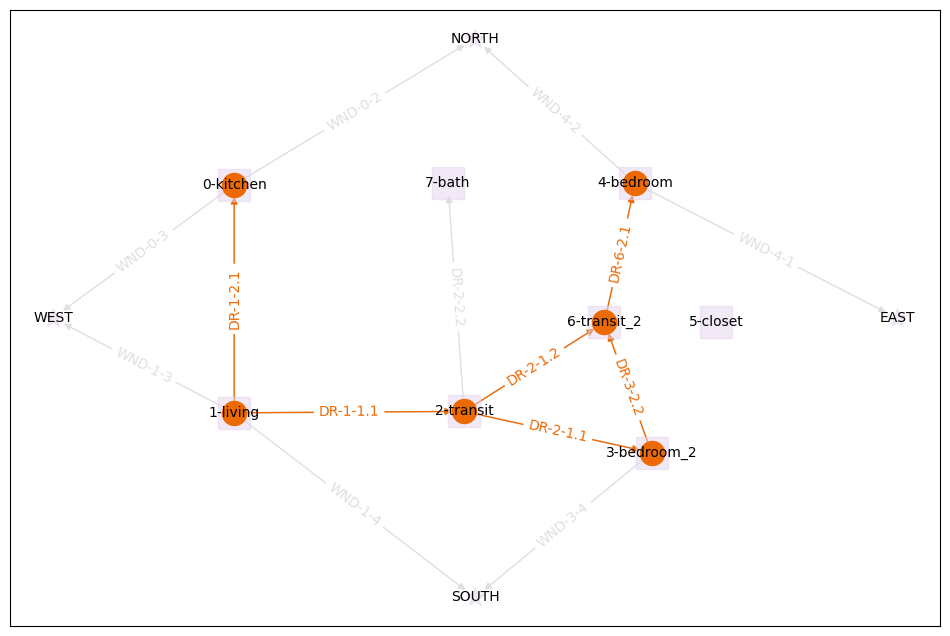

In [89]:
G, positions = create_base_graph(idf, path_to_input)
G_afn_node, G_afn_edge = create_afn_graph(idf, G)
fig = draw_afn_comparison(idf, G, G_afn_node, positions)

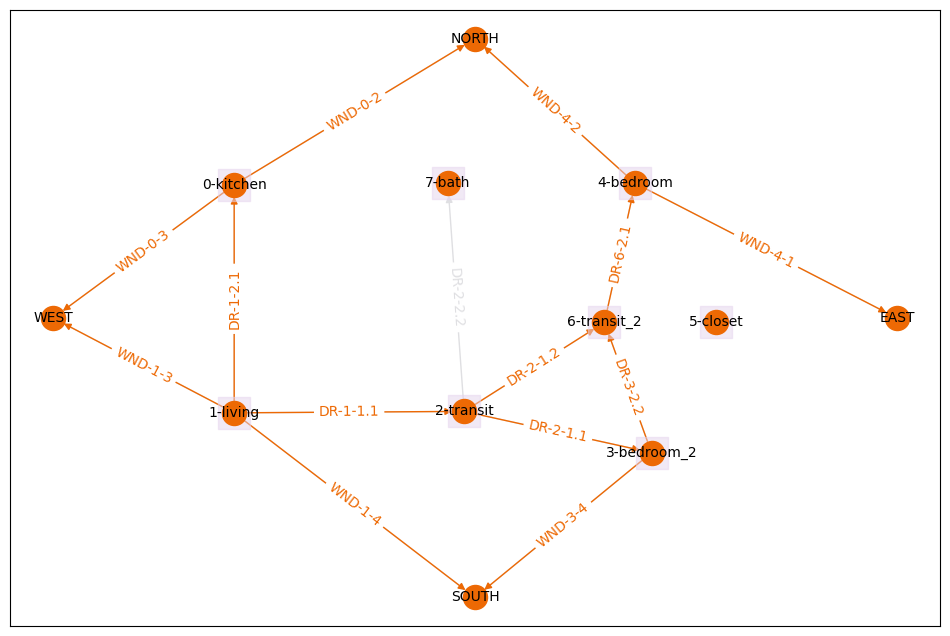

In [90]:
fig = draw_afn_comparison(idf, G, G_afn_edge, positions)

In [80]:
def set_difference(s_large:Iterable, s2:Iterable):
    return list(set(s_large).difference(set(s2)))

In [81]:
zone_map = create_zone_map_without_partners(idf)
filtered_zone_map = d2 = {k: v for k, v in zone_map.items() if len(v) < 2}
afn_zones = set_difference(zone_map.keys(), filtered_zone_map.keys())
afn_zones

['Block 00 Storey 0',
 'Block 04 Storey 0',
 'Block 01 Storey 0',
 'Block 06 Storey 0',
 'Block 03 Storey 0',
 'Block 02 Storey 0']

In [84]:
def list_all_dict_values(d:dict):
    return chain_flatten([v for v in d.values()])

In [85]:
afn_subsurfaces = set_difference(list_all_dict_values(zone_map), list_all_dict_values(filtered_zone_map))

['Block 03 Storey 0 Wall 0002_2 Door',
 'Block 04 Storey 0 Wall 0001 Window',
 'Block 06 Storey 0 Wall 0002_1 Door',
 'Block 01 Storey 0 Wall 0003 Window',
 'Block 01 Storey 0 Wall 0002_1 Door',
 'Block 03 Storey 0 Wall 0004 Window',
 'Block 00 Storey 0 Wall 0002 Window',
 'Block 01 Storey 0 Wall 0004 Window',
 'Block 02 Storey 0 Wall 0001_1 Door',
 'Block 00 Storey 0 Wall 0003 Window',
 'Block 04 Storey 0 Wall 0002 Window',
 'Block 01 Storey 0 Wall 0001_1 Door',
 'Block 02 Storey 0 Wall 0001_2 Door']